        Data Fields

**[] fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.

**[x] channelGrouping** - The channel via which the user came to the Store. 

**[x] date** - The date on which the user visited the Store.

**[x] device** - The specifications for the device used to access the Store.

**[x] geoNetwork** - This section contains information about the geography of the user.

**[] sessionId** - A unique identifier for this visit to the store.

**[x] socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".

**[x] totals** - This section contains aggregate values across the session.

**[x] trafficSource** - This section contains information about the Traffic Source from which the session originated.

**[] visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

**[] visitNumber** - The session number for this user. If this is the first session, then this is set to 1.

**[] visitStartTime** - The timestamp (expressed as POSIX time).

In [0]:
# Import libraries
import pandas as pd
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Function to read data from JSON format**

In [0]:
def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

#print(os.listdir("../input/train-v1"))

['train.csv', 'test.csv']


In [0]:
%%time
train_origin = load_df()
test_origin = load_df("data/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 5min 5s, sys: 9.46 s, total: 5min 15s
Wall time: 5min 15s


In [0]:
train_origin.shape, test_origin.shape

((903653, 55), (804684, 53))

In [0]:
train_origin.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

**Analyzing target**

The target we want to predict, transactionRevenue, is contained in one of the JSON columns, ie. the totals column. While loading the dataset, it was renamed as totals.transactionRevenue. The target only contains a few non-null values and before taking its log, we fill the NAs:

In [0]:
target = train_origin['totals.transactionRevenue'].fillna(0).astype(float)
print(np.mean(target))

1704272.8126836296


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


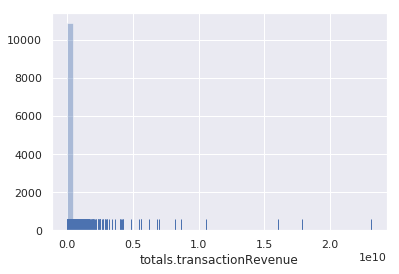

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)
sns.distplot(target[target > 0], kde=False, rug=True);

**Fill Nan Value for all other attributes**

In [0]:
columns_to_remove = [col for col in train_origin.columns if train_origin[col].nunique() == 1]
print("Nb. of variables with unique value: {}".format(len(columns_to_remove)))

for col in columns_to_remove:
    if set(['not available in demo dataset']) ==  set(train_origin[col].unique()): continue
    print(col, train_origin[col].dtypes, train_origin[col].unique())

Nb. of variables with unique value: 24
socialEngagementType object ['Not Socially Engaged']
totals.bounces object ['1' nan]
totals.newVisits object ['1' nan]
totals.visits object ['1']
trafficSource.adwordsClickInfo.isVideoAd object [nan False]
trafficSource.campaignCode object [nan '11251kjhkvahf']
trafficSource.isTrueDirect object [nan True]


In [0]:
# Do not remove columns with unique value and NAN, update value for NAN
train_origin['totals.bounces'] = train_origin['totals.bounces'].fillna('0')
test_origin['totals.bounces'] = test_origin['totals.bounces'].fillna('0')

train_origin['totals.newVisits'] = train_origin['totals.newVisits'].fillna('0')
test_origin['totals.newVisits'] = test_origin['totals.newVisits'].fillna('0')

train_origin['trafficSource.adwordsClickInfo.isVideoAd'] = train_origin['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True)
test_origin['trafficSource.adwordsClickInfo.isVideoAd'] = test_origin['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True)

train_origin['trafficSource.isTrueDirect'] = train_origin['trafficSource.isTrueDirect'].fillna(False)
test_origin['trafficSource.isTrueDirect'] = test_origin['trafficSource.isTrueDirect'].fillna(False)


**Clear rare categories**

In [0]:
# Remove column not in test but in train, should we?
print("Columns in Train but NOT in Test:")
for col in train_origin.columns:
    if col not in test_origin.columns:
        print(col)
print("Columns in Test but NOT in Traing:")
for col in test_origin.columns:
    if col not in train_origin.columns:
        print(col)
train_origin['trafficSource.campaignCode'].value_counts()
# trafficSource.campaignCode is redundant, we will not use for training/testing

Columns in Train but NOT in Test:
totals.transactionRevenue
trafficSource.campaignCode
Columns in Test but NOT in Traing:


11251kjhkvahf    1
Name: trafficSource.campaignCode, dtype: int64

In [0]:
def clearRare(columnname, limit = 100):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test_origin[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")

    train_origin.loc[train_origin[columnname].map(lambda x: x not in common), columnname] = 'other'
    test_origin.loc[test_origin[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train_origin[columnname].nunique(), "categories in train")

**Fill NAN exhausted**

In [0]:
train_origin.fillna(0, inplace=True)
test_origin.fillna(0, inplace=True)

In [0]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.metro")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("trafficSource.adContent")
clearRare("trafficSource.campaign")
clearRare("trafficSource.keyword")
clearRare("trafficSource.medium")
clearRare("trafficSource.referralPath")
clearRare("trafficSource.source")

Set 92 device.browser categories to 'other'; now there are 17 categories in train
Set 10 device.operatingSystem categories to 'other'; now there are 11 categories in train
Set 97 geoNetwork.country categories to 'other'; now there are 123 categories in train
Set 511 geoNetwork.city categories to 'other'; now there are 209 categories in train
Set 52 geoNetwork.metro categories to 'other'; now there are 56 categories in train
Set 25254 geoNetwork.networkDomain categories to 'other'; now there are 490 categories in train
Set 209 geoNetwork.region categories to 'other'; now there are 163 categories in train
Set 3 geoNetwork.subContinent categories to 'other'; now there are 21 categories in train
Set 34 trafficSource.adContent categories to 'other'; now there are 7 categories in train
Set 11 trafficSource.campaign categories to 'other'; now there are 5 categories in train
Set 2393 trafficSource.keyword categories to 'other'; now there are 21 categories in train
Set 1 trafficSource.medium ca

In [0]:
test_origin.shape, train_origin.shape

((804684, 53), (903653, 55))

**Convert Date into Understandable format**

In [0]:
for df in [train_origin, test_origin]:
    df_date = pd.to_datetime(df['visitStartTime'], unit='s')
    df['sess_date_dow'] = df_date.dt.dayofweek
    df['sess_date_hours'] = df_date.dt.hour
    df['sess_date_dom'] = df_date.dt.day
train_origin.shape, test_origin.shape

((903653, 58), (804684, 56))

**Analyzing transaction time of dataset**

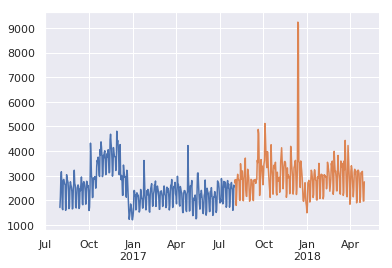

In [0]:
train_date = pd.to_datetime(train_origin.date, format="%Y%m%d")
test_date = pd.to_datetime(test_origin.date, format="%Y%m%d")
train_date.value_counts().sort_index().plot(label="train")
test_date.value_counts().sort_index().plot(label="test")
# plt.legend()

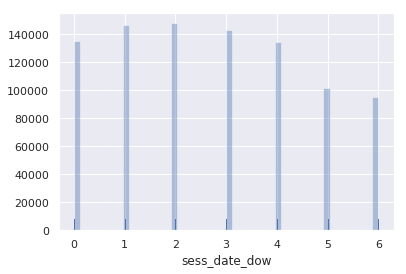

In [0]:
# distribution by day of week
sns.set(color_codes=True)
sns.distplot(train_origin['sess_date_dow'], kde=False, rug=True);

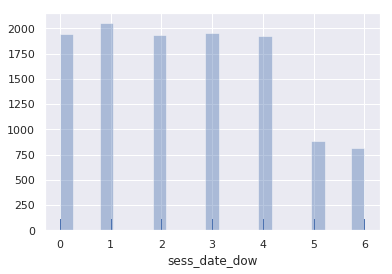

In [0]:
# Show date of week when people have made transactions
dateWeek = train_origin[train_origin['totals.transactionRevenue'] != 0]
sns.distplot(dateWeek['sess_date_dow'], kde=False, rug=True);

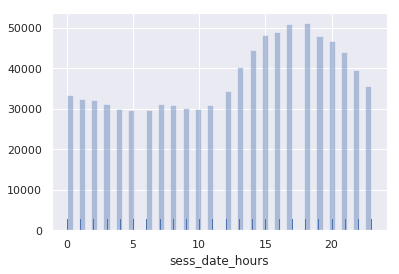

In [0]:
# distribution by hour of day
sns.distplot(train_origin['sess_date_hours'], kde=False, rug=True);

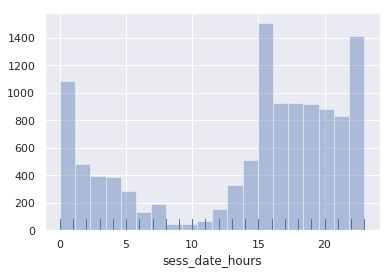

In [0]:
# Show hours when people have made transactions
hourDate = train_origin[train_origin['totals.transactionRevenue'] != 0]
sns.distplot(hourDate['sess_date_hours'], kde=False, rug=True);

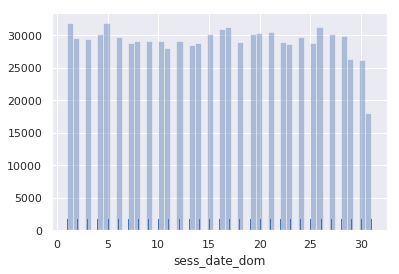

In [0]:
# distribution by day of month
sns.distplot(train_origin['sess_date_dom'], kde=False, rug=True);

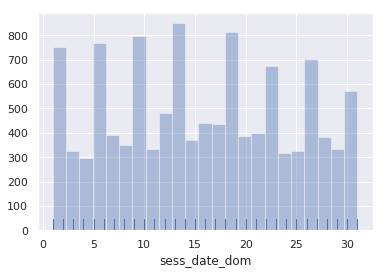

In [0]:
# Show date of month when people have done transactions
dateMonth = train_origin[train_origin['totals.transactionRevenue'] != 0]
sns.distplot(dateMonth['sess_date_dom'], kde=False, rug=True);

In [0]:
for col in train_origin.columns:
    print(col, train_origin[col].dtype)

channelGrouping object
date int64
fullVisitorId object
sessionId object
socialEngagementType object
visitId int64
visitNumber int64
visitStartTime int64
device.browser object
device.browserSize object
device.browserVersion object
device.deviceCategory object
device.flashVersion object
device.isMobile bool
device.language object
device.mobileDeviceBranding object
device.mobileDeviceInfo object
device.mobileDeviceMarketingName object
device.mobileDeviceModel object
device.mobileInputSelector object
device.operatingSystem object
device.operatingSystemVersion object
device.screenColors object
device.screenResolution object
geoNetwork.city object
geoNetwork.cityId object
geoNetwork.continent object
geoNetwork.country object
geoNetwork.latitude object
geoNetwork.longitude object
geoNetwork.metro object
geoNetwork.networkDomain object
geoNetwork.networkLocation object
geoNetwork.region object
geoNetwork.subContinent object
totals.bounces object
totals.hits object
totals.newVisits object
total

**Create feature list**

In [0]:
excluded_features = [
    'date', 'sessionId', 'fullVisitorId', 
    'totals.transactionRevenue', 'trafficSource.campaignCode',
    'visitId', 'visitStartTime','visitNumber'
]

no_object_columns = ['device.isMobile', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect',
                    'sess_date_dow', 'sess_date_hours', 'sess_date_dom']

categorical_features = [
    _f for _f in train_origin.columns
    if (_f not in excluded_features) # & (train_df[_f].dtype == 'object')
]
print("Number of selected features : ",len(categorical_features))

Number of selected features :  50


**Final columns after filter columns with unique values**

In [0]:
columns = [col for col in train_origin.columns if  train_origin[col].nunique() > 1 and (col in categorical_features)]
print(len(columns))
print(columns)

31
['channelGrouping', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source', 'sess_date_dow', 'sess_date_hours', 'sess_date_dom']


**DONE for select feature and factorizing dataset**

**DATA Visualization**

In [0]:
train_origin['geoNetwork.continent'].value_counts()

Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: geoNetwork.continent, dtype: int64

In [0]:
# Analysis total revenue by continent
ttt = train_origin[train_origin['totals.transactionRevenue'] != 0].copy()
ttt['totals.transactionRevenue'] = ttt['totals.transactionRevenue'].astype(float)
ttt.groupby(by='geoNetwork.continent')['totals.transactionRevenue'].sum()

geoNetwork.continent
(not set)    7.697800e+08
Africa       8.687760e+09
Americas     1.504672e+12
Asia         1.740184e+10
Europe       6.747030e+09
Oceania      1.793230e+09
Name: totals.transactionRevenue, dtype: float64

In [0]:
def drawBars(columnname):
    sns.barplot(x="count", y="index", hue="dataset",
        data=pd.melt(pd.concat([train_origin[columnname].value_counts().rename("train"), 
                       test_origin[columnname].value_counts().rename("test")], axis=1, sort="False").reset_index(),
            id_vars="index", var_name="dataset", value_name="count"))

In [0]:
#find country where total_transactionRevenue > 0
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [0]:
def plot_countryMap(data, country, nvisits, visits, title, colormap='Viridis'):
    data = dict(type = 'choropleth', 
                colorscale = colormap,
                autocolorscale = False,
                reversescale = False,
               locations = data[country],
               locationmode = 'country names',
               z = data[nvisits], 
               text = data[nvisits],
               colorbar = {'title':visits})
    layout = dict(title = title, 
                 geo = dict(showframe = False, 
                         projection = {'type': 'natural earth'}))
    choromap = go.Figure(data = [data], layout=layout)
    iplot(choromap)

In [0]:
#visits per country
countries = train_origin['geoNetwork.country'].value_counts()
countryVisits = pd.DataFrame(data={'geoNetwork_country': countries.values}, index=countries.index).reset_index()
countryVisits.columns = ['Country', 'Visits']
plot_countryMap(countryVisits, 'Country', 'Visits', 'Visits', 'Visits per country')

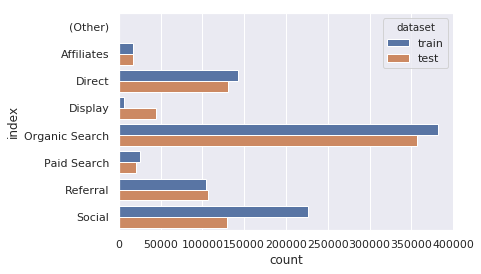

In [0]:
drawBars("channelGrouping")

In [0]:
#visits with non-zero transaction
nonZero = train_origin[train_origin['totals.transactionRevenue'] != 0].copy()
countries = nonZero['geoNetwork.country'].value_counts()
countryVisits = pd.DataFrame(data={'geoNetwork_country': countries.values}, index=countries.index).reset_index()
countryVisits.columns = ['Country', 'Visits']
plot_countryMap(countryVisits, 'Country', 'Visits', 'Visits', 'Visits with non-zero transaction per country')

In [0]:
ids_train = set(train_origin.fullVisitorId.unique())
ids_test = set(test_origin.fullVisitorId.unique())
print("Unique visitor ids in train:", len(ids_train))
print("Unique visitor ids in test:", len(ids_test))
print("Common visitors in train and test:", len(ids_train & ids_test))

Unique visitor ids in train: 714167
Unique visitor ids in test: 617242
Common visitors in train and test: 7679


In [0]:
print("Train: ", np.bincount(train_origin.visitId.value_counts()))
print("test: ", np.bincount(test_origin.visitId.value_counts()))

Train:  [     0 869452  16410    396     38      3      3      0      1]
test:  [     0 759983  17805    978    261    110     62     36     18     17
     24     12     15     24     22     24     19     21     21     23
      9      8      5      2      2      0      1      0      2]



**Factorization**

In [0]:
object_columns = [i for i in columns if i not in no_object_columns]
for f in object_columns:
    print(f)
    train_origin[f], indexer = pd.factorize(train_origin[f])
    test_origin[f] = indexer.get_indexer(test_origin[f])
train_origin["totals.transactionRevenue"] = train_origin["totals.transactionRevenue"].fillna(0).astype(int)
train_origin["totals.transactionRevenue"] = train_origin["totals.transactionRevenue"].astype('int')
train_origin.head(10)

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
totals.bounces
totals.hits
totals.newVisits
totals.pageviews
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom
0,0,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,0,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,0,0,not available in demo dataset,not available in demo dataset,0,0,not available in demo dataset,0,0,0,0,0,0,0,1,0,0,not available in demo dataset,0,True,0,0,0,0,False,0,0,0,0,4,15,2
1,0,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,1,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,1,1,not available in demo dataset,not available in demo dataset,1,1,not available in demo dataset,1,1,0,0,0,0,0,1,0,0,not available in demo dataset,0,True,0,0,0,0,False,0,0,0,0,5,5,3
2,0,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,0,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,not available in demo dataset,not available in demo dataset,2,not available in demo dataset,2,2,not available in demo dataset,not available in demo dataset,0,2,not available in demo dataset,2,2,0,0,0,0,0,1,0,0,not available in demo dataset,0,True,0,0,0,0,False,0,0,0,0,5,1,3
3,0,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,2,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,2,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,0,3,not available in demo dataset,not available in demo dataset,1,2,not available in demo dataset,1,3,0,0,0,0,0,1,0,0,not avai

**Build Models**

**Classify non-zero revenues**

There are only 1.3% of the sessions have a non-zero revenue. Thus, we first CLASSIFY session, and then using regression on non-zero set.

In [0]:
train_df = train_origin.copy()
test_df = test_origin.copy()

In [0]:
from sklearn.model_selection import train_test_split
x = train_df[columns]
y = train_df["totals.transactionRevenue"]
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [0]:
y_valid[y_valid > 0].shape, y_train[y_train > 0].shape

((2271,), (9244,))

In [0]:
# Transfer target into format of [0, 1]
y_train01 = y_train.copy()
y_train01[y_train01 > 0] = 1

y_valid01 = y_valid.copy()
y_valid01[y_valid01 > 0] = 1

In [0]:
# Ratio of classification 0, 1
y_train01.value_counts() / y_train01.shape[0]

0    0.987213
1    0.012787
Name: totals.transactionRevenue, dtype: float64

**Visualize data distribution using PCA**

([], <a list of 0 Text yticklabel objects>)

<Figure size 432x288 with 0 Axes>

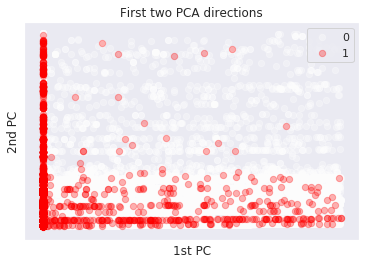

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2).fit(x)
X_reduced = pca.transform(x)

yy = y.copy()
yy[yy>0] = 1

plt.clf()
fig, ax = plt.subplots()

# Plot the training points
labels = ['0','1']
colors = ['white','red']
for i in range(2):   
    ax.scatter(X_reduced[yy==i, 0], X_reduced[yy==i, 1], c=colors[i],label = labels[i],cmap=plt.cm.Set1,s=40,
                edgecolor=None,alpha=0.3)


plt.title("First two PCA directions")
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
ax.legend()
plt.xticks(())
plt.yticks(())

**XGBoost Classifier**

*Paramters tuning:* learning rate,
n estimators,
min child weight,
max delta step, booster,
seed

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()
xgb_param = {'n_estimators':[100, 500, 1000]}

clf = GridSearchCV(xgb, xgb_param, cv=5, verbose=True, scoring='f1')
clf.fit(x_train,y_train01)

In [0]:
clf.best_estimator_

In [0]:
y_pred = clf.predict(x_train)
y_pred_valid = clf.predict(x_valid)
print("f1 score:")
print("Train data: " + str(f1_score(y_train01, y_pred)))
print("Test data: " + str(f1_score(y_valid01, y_pred_valid)))

print()
print("Accuracy Score:")
print("Train data: " + str(accuracy_score(y_train01, y_pred)))
print("Test data: " + str(accuracy_score(y_valid01, y_pred_valid)))
print()

print("ROC AUC Score:")
print("Train data: " + str(roc_auc_score(y_train01, y_pred)))
print("Test data: " + str(roc_auc_score(y_valid01, y_pred_valid)))
print()

#Confusion Matrix
print("Confusion Matrix")
y_actual = pd.Series(y_valid01, name='Actual')
y_predict = pd.Series(y_pred_valid, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predict)
print(df_confusion)

plt.figure(figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
plt.matshow(df_confusion, cmap='viridis')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.ylabel(df_confusion.index.name)
plt.xlabel(df_confusion.columns.name)

In [0]:
# Predict test
y_submit_xgb = clf.predict(test_df[columns])
y_submit_xgb[y_submit_xgb > 0] = 10272.0
pd.Series(y_submit_xgb).value_counts()

In [0]:
# Prediction
y_submit = clf.predict(test_df[columns])

In [0]:
#Predicted revenue per customer
submission = test_origin[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = y_submit
grouped_test_RF = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test_RF["PredictedLogRevenue"] = np.log1p(grouped_test_RF["PredictedLogRevenue"])
print(grouped_test_RF)

**Random Forest**

*Tuning paramters*
n_estimators,
criterion,
max_depth,
max_features,
min_samples_split,
min_samples_leaf

In [0]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
rf_param = {'n_estimators':[100, 500, 1000]}

clf_rf = GridSearchCV(rf,rf_param,cv=5,verbose=True,scoring='f1')
clf_rf.fit(x_train,y_train01)

In [0]:
clf_rf.best_estimator_

In [0]:
y_pred = clf_rf.predict(x_train)
y_pred_valid = clf_rf.predict(x_valid)

print("f1 score:")
print("Train data: " + str(f1_score(y_train01, y_pred)))
print("Test data: " + str(f1_score(y_valid01, y_pred_valid)))

print()
print("Accuracy Score:")
print("Train data: " + str(accuracy_score(y_train01, y_pred)))
print("Test data: " + str(accuracy_score(y_valid01, y_pred_valid)))
print()

print("ROC AUC Score:")
print("Train data: " + str(roc_auc_score(y_train01, y_pred)))
print("Test data: " + str(roc_auc_score(y_valid01, y_pred_valid)))
print()

#Confusion Matrix
print("Confusion Matrix")
y_actual = pd.Series(y_valid01, name='Actual')
y_predict = pd.Series(y_pred_valid, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predict)
print(df_confusion)

plt.figure(figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
plt.matshow(df_confusion, cmap='viridis')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.ylabel(df_confusion.index.name)
plt.xlabel(df_confusion.columns.name)

In [0]:
# Predict test
y_submit_rf = clf_rf.predict(test_df[columns])
y_submit_rf[y_submit_rf > 0] = 10272.0
pd.Series(y_submit_rf).value_counts()

In [0]:
# Prediction
y_submit = clf_rf.predict(test_df[columns])

In [0]:
#Predicted Revenue per customer output
submission = test_origin[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = y_submit
grouped_test_RF = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test_RF["PredictedLogRevenue"] = np.log1p(grouped_test_RF["PredictedLogRevenue"])
print(grouped_test_RF)

**Ensemble learning of classifiers RF + XGB**

In [0]:
y_combination = (y_submit_rf + y_submit_xgb) / 2

In [0]:
print("Confusion Matrix")
y_actual = pd.Series(y_valid01, name='Actual')
y_predict = pd.Series(y_combination, name='Predicted')
df_confusion = pd.crosstab(y_actual, y_predict)
print(df_confusion)

plt.figure(figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
plt.matshow(df_confusion, cmap='viridis')
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.ylabel(df_confusion.index.name)
plt.xlabel(df_confusion.columns.name)

In [0]:
#Predicted revenue per customer
submission = test_origin[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = y_combination
grouped_test_RF = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test_RF["PredictedLogRevenue"] = np.log1p(grouped_test_RF["PredictedLogRevenue"])
grouped_test_RF.to_csv('submit_Clf.csv',index=False)
print(grouped_test_RF)

**Predict revenues for non-zero**

In [0]:
train_origin[columns].head()

,channelGrouping,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom
0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,0,0,0,False,0,0,0,0,4,15,2
1,0,1,0,False,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,True,0,0,0,False,0,0,0,0,5,5,3
2,0,0,0,False,0,2,2,2,0,2,2,2,0,0,0,0,0,0,0,True,0,0,0,False,0,0,0,0,5,1,3
3,0,2,0,False,2,1,0,3,1,2,1,3,0,0,0,0,0,0,0,True,0,0,0,False,1,0,0,0,5,5,3
4,0,0,1,True,3,1,2,4,1,2,1,4,0,0,1,0,0,0,0,True,0,0,0,True,0,0,0,0,4,13,2


In [0]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['fullVisitorId'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["totals.transactionRevenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["totals.transactionRevenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
        print("Confusion Matrix")
        y_actual = pd.Series(y_valid, name='Actual')
        y_predict = pd.Series(predictions, name='Predicted')
        df_confusion = pd.crosstab(y_actual, y_predict)
        print(df_confusion)

        plt.figure(figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
        plt.matshow(df_confusion, cmap='viridis')
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(df_confusion.columns))
        plt.xticks(tick_marks, df_confusion.columns, rotation=45)
        plt.yticks(tick_marks, df_confusion.index)
        plt.ylabel(df_confusion.index.name)
        plt.xlabel(df_confusion.columns.name)        
        print("Final score: ", full_score)
        return full_score

In [0]:
Kfolder = KFoldValidation(train_df)

**LGBMRegressor**

In [0]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.67924
[200]	valid_0's rmse: 1.65625
[300]	valid_0's rmse: 1.64962
[400]	valid_0's rmse: 1.64566
[500]	valid_0's rmse: 1.64321
[600]	valid_0's rmse: 1.64258
[700]	valid_0's rmse: 1.64239
Early stopping, best iteration is:
[659]	valid_0's rmse: 1.6423
Fold  0  error:  1.6415677826278077
Fold  0  score:  1.6220760418607434


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.65448
[200]	valid_0's rmse: 1.63494
[300]	valid_0's rmse: 1.63022
[400]	valid_0's rmse: 1.62786
[500]	valid_0's rmse: 1.62564
Early stopping, best iteration is:
[492]	valid_0's rmse: 1.62559
Fold  1  error:  1.6249364652721057
Fold  1  score:  1.6175267192591416


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.67054
[200]	valid_0's rmse: 1.64962
[300]	valid_0's rmse: 1.64375
[400]	valid_0's rmse: 1.64059
[500]	valid_0's rmse: 1.63868
[600]	valid_0's rmse: 1.63787
Early stopping, best iteration is:
[642]	valid_0's rmse: 1.63752
Fold  2  error:  1.6367853762075546
Fold  2  score:  1.6225590787324335


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Fold  3 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.65129
[200]	valid_0's rmse: 1.63049
[300]	valid_0's rmse: 1.62602
[400]	valid_0's rmse: 1.62281
[500]	valid_0's rmse: 1.6217
[600]	valid_0's rmse: 1.62083
Early stopping, best iteration is:
[643]	valid_0's rmse: 1.62053
Fold  3  error:  1.6197065407983604
Fold  3  score:  1.5974193684622846


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Fold  4 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.69187
[200]	valid_0's rmse: 1.6735
[300]	valid_0's rmse: 1.66853
[400]	valid_0's rmse: 1.66489
[500]	valid_0's rmse: 1.66333
[600]	valid_0's rmse: 1.66215
[700]	valid_0's rmse: 1.66189
Early stopping, best iteration is:
[708]	valid_0's rmse: 1.66164
Fold  4  error:  1.660913699068587
Fold  4  score:  1.6296907107344552


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Confusion Matrix
Predicted  0.000000e+00  2.033870e-07      ...       1.553394e+01  1.576198e+01
Actual                                     ...                                 
0.000000          17690             1      ...                  1             1
14.503646             1             0      ...                  0             0
14.910784             1             0      ...                  0             0
15.065413             0             0      ...                  0             0
15.068274             0             0      ...                  0             0
15.196793             0             0      ...                  0             0
15.516616             0             0      ...                  0             0
15.667110             0             0      ...                  0             0
15.670245             0             0      ...                  0             0
15.788202             0             0      ...                  0             0
15.889940             0

1.6178543838098116

<Figure size 1200x1200 with 0 Axes>

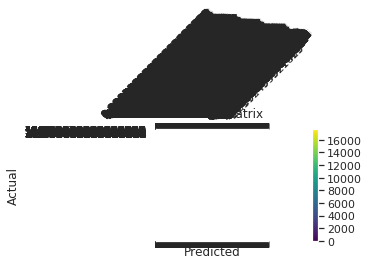

In [0]:
Kfolder.validate(train_df, test_df, columns, lgbmodel, "lgbpred", prepare_stacking=True)

In [0]:
# Prediction
y_submit = lgbmodel.predict(test_df[columns])

In [0]:
# output to file
submission = test_origin[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = y_submit
grouped_test_LGB = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test_LGB["PredictedLogRevenue"] = np.log1p(grouped_test_LGB["PredictedLogRevenue"])
grouped_test_LGB["PredictedLogRevenue"] = grouped_test_LGB["PredictedLogRevenue"].fillna(0).astype(float)
grouped_test_LGB.to_csv('submit_reg_lgb.csv',index=False)
test_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in log1p



,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom,lgbpred
0,0,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,0,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,not available in demo dataset,8,not available in demo dataset,0,13,not available in demo dataset,not available in demo dataset,0,416,not available in demo dataset,6,3,1,3,1,3,1,0,0,not available in demo dataset,0,True,0,0,0,True,0,0,0,0,0,10,16,0.000000
1,0,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,0,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,not available in demo dataset,not available in demo dataset,147,not available in demo dataset,2,2,not available in demo dataset,not available in demo dataset,0,23,not available in demo dataset,116,2,1,4,0,4,1,0,0,not available in demo dataset,0,True,0,0,0,False,0,0,0,0,0,17,16,0.000127
2,0,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,0,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,2,10,not available in demo dataset,not available in demo dataset,1,175,not available in demo dataset,1,6,1,6,0,6,1,0,0,not available in demo dataset,0,True,0,0,0,False,0,0,0,0,0,8,16,0.000289
3,0,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,4,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,4,not available in demo dataset,not available in demo dataset,not available in demo dataset,23,not available in demo dataset,3,33,not available in demo dataset,not available in demo dataset,3,16,not available in demo dataset,22,10,1,7,0,3,1,0,0,not available in dem

**Cat Model**


In [0]:
catmodel = cat.CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=5, random_seed=2019)

Fold  0 :
0:	learn: 1.9158310	test: 1.9303453	best: 1.9303453 (0)	total: 249ms	remaining: 4m 8s
100:	learn: 1.6385957	test: 1.6651540	best: 1.6649663 (97)	total: 17s	remaining: 2m 31s
200:	learn: 1.6160417	test: 1.6584677	best: 1.6584677 (200)	total: 33.4s	remaining: 2m 12s
300:	learn: 1.6007799	test: 1.6571506	best: 1.6571464 (299)	total: 49.6s	remaining: 1m 55s
400:	learn: 1.5870343	test: 1.6559798	best: 1.6559167 (399)	total: 1m 5s	remaining: 1m 38s
500:	learn: 1.5763807	test: 1.6561253	best: 1.6547867 (449)	total: 1m 22s	remaining: 1m 22s
600:	learn: 1.5660993	test: 1.6562174	best: 1.6547867 (449)	total: 1m 38s	remaining: 1m 5s
700:	learn: 1.5565193	test: 1.6559957	best: 1.6547867 (449)	total: 1m 55s	remaining: 49.2s
800:	learn: 1.5481142	test: 1.6574538	best: 1.6547867 (449)	total: 2m 11s	remaining: 32.8s
900:	learn: 1.5405191	test: 1.6583884	best: 1.6547867 (449)	total: 2m 28s	remaining: 16.3s
999:	learn: 1.5335255	test: 1.6580973	best: 1.6547867 (449)	total: 2m 44s	remaining: 0u

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Fold  1 :
0:	learn: 1.9233678	test: 1.9007666	best: 1.9007666 (0)	total: 198ms	remaining: 3m 17s
100:	learn: 1.6394463	test: 1.6422247	best: 1.6422247 (100)	total: 17.1s	remaining: 2m 32s
200:	learn: 1.6207340	test: 1.6390449	best: 1.6385312 (185)	total: 33.4s	remaining: 2m 12s
300:	learn: 1.6032686	test: 1.6374682	best: 1.6374456 (295)	total: 49.8s	remaining: 1m 55s
400:	learn: 1.5910580	test: 1.6380550	best: 1.6372950 (327)	total: 1m 6s	remaining: 1m 38s
500:	learn: 1.5798012	test: 1.6395220	best: 1.6372950 (327)	total: 1m 22s	remaining: 1m 22s
600:	learn: 1.5693280	test: 1.6395019	best: 1.6372950 (327)	total: 1m 39s	remaining: 1m 5s
700:	learn: 1.5605028	test: 1.6406582	best: 1.6372950 (327)	total: 1m 55s	remaining: 49.2s
800:	learn: 1.5513550	test: 1.6417721	best: 1.6372950 (327)	total: 2m 11s	remaining: 32.8s
900:	learn: 1.5435555	test: 1.6429500	best: 1.6372950 (327)	total: 2m 28s	remaining: 16.3s
999:	learn: 1.5359344	test: 1.6432283	best: 1.6372950 (327)	total: 2m 44s	remaining

Final score:  1.6274764445009735


1.6274764445009735

<Figure size 1200x1200 with 0 Axes>

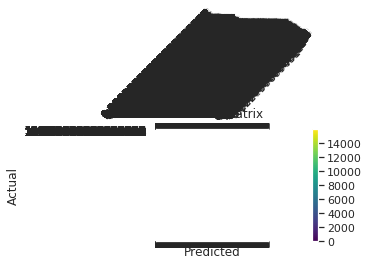

In [0]:
Kfolder.validate(train_df, test_df, columns, catmodel, name="catpred", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})

In [0]:
# Prediction
y_submit = catmodel.predict(test_df[columns])

In [0]:
# output to file
submission = test_origin[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = y_submit
grouped_test_CAT = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test_CAT["PredictedLogRevenue"] = np.log1p(grouped_test_CAT["PredictedLogRevenue"])
grouped_test_CAT["PredictedLogRevenue"] = grouped_test_CAT["PredictedLogRevenue"].fillna(0).astype(float)
grouped_test_CAT.to_csv('submit_reg_cat.csv',index=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in log1p



In [0]:
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,sess_date_dow,sess_date_hours,sess_date_dom,lgbpred,catpred
0,0,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,0,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,not available in demo dataset,8,not available in demo dataset,0,13,not available in demo dataset,not available in demo dataset,0,416,not available in demo dataset,6,3,1,3,1,3,1,0,0,not available in demo dataset,0,True,0,0,0,True,0,0,0,0,0,10,16,0.000000,0.003411
1,0,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,0,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,not available in demo dataset,not available in demo dataset,147,not available in demo dataset,2,2,not available in demo dataset,not available in demo dataset,0,23,not available in demo dataset,116,2,1,4,0,4,1,0,0,not available in demo dataset,0,True,0,0,0,False,0,0,0,0,0,17,16,0.000127,0.001367
2,0,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,0,not available in demo dataset,not available in demo dataset,0,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,2,10,not available in demo dataset,not available in demo dataset,1,175,not available in demo dataset,1,6,1,6,0,6,1,0,0,not available in demo dataset,0,True,0,0,0,False,0,0,0,0,0,8,16,0.000289,0.004039
3,0,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,4,not available in demo dataset,not available in demo dataset,1,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,4,not available in demo dataset,not available in demo dataset,not available in demo dataset,23,not available in demo dataset,3,33,not available in demo dataset,not available in demo dataset,3,16,not available in demo dataset,22,10

**Ensemble learning **

In this part, we use result of models (LGB, CAT) for ensemble learning

In [0]:
train_df['PredictedLogRevenue'] = 0.6 * train_df["lgbpred"] + 0.4 * train_df["catpred"] 
score(train_df, train_df.PredictedLogRevenue)

1.6193379375212846

In [0]:
test_df['PredictedLogRevenue'] = 0.6 * test_df["lgbpred"] +  0.4 * test_df["catpred"]
y_submit =  test_df['PredictedLogRevenue']

In [0]:
# output to file
submission = test_origin[['fullVisitorId']].copy()
submission.loc[:, 'PredictedLogRevenue'] = y_submit
grouped_test_ENS = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test_ENS["PredictedLogRevenue"] = np.log1p(grouped_test_ENS["PredictedLogRevenue"])
grouped_test_ENS["PredictedLogRevenue"] = grouped_test_ENS["PredictedLogRevenue"].fillna(0).astype(float)
grouped_test_ENS.to_csv('submit_reg_ens.csv',index=False)
grouped_test_ENS.head()

**======== THE END ========**